In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import acquire
import prepare
import model

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
#acquire data and do rudimentary exploration
df = acquire.get_telco_data()
df.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,Mailed check,DSL
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,1,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic
3,2,1,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Mailed check,Fiber optic


In [3]:
# reassign with prep_telco output to prepare for data split
df = prepare.prep_telco(df)
df = prepare.final_prep(df)

In [5]:
# split the data with target *churn*
train, validate, test = prepare.split_data(df, 'churn_encoded')

Prepared df: (7043, 31)

Train: (4225, 31)
Validate: (1409, 31)
Test: (1409, 31)


# Model
Explore various models and feature combinations.
Choose **three** models to validate. Choose **one** to test. 
Artifact: `model.py`

### Modeling Preparation
> Create Baseline prediction and accuracy
* Place results in dataframe that features model description for addtion of later models --> `model_descriptions`
> Create dataframe model evaluation metrics --> move to `model.py`
* `comparision_chart`
> Create functions to  --> move to `model.py`
> update dataframes with each model in turn
> create visualization of each model's accuracy

### Baseline Prediction and Accuracy

In [6]:
# formulate baseline prediction
train.churn_encoded.value_counts(normalize=True)

0    0.734675
1    0.265325
Name: churn_encoded, dtype: float64

In [7]:
# split data into Big X, small y sets 
X_train = train.drop(columns=['churn_encoded', 'tenure_group'])
y_train = train.churn_encoded
X_train = prepare.final_prep(X_train)

X_validate = validate.drop(columns=['churn_encoded'])
y_validate = validate.churn_encoded
X_validate = prepare.final_prep(X_validate)

X_test = test.drop(columns=['churn_encoded'])
y_test = test.churn_encoded
X_test = prepare.final_prep(X_test)

KeyError: "['tenure_group'] not found in axis"

In [ ]:
# formulate baseline accuracy
baseline_accuracy = (y_train == 0).mean()

print(f'Baseline Accuracy for \"no churn\" prediction on Telco dataset: {(baseline_accuracy * 100): .3}%')

Baseline Accuracy for "no churn" prediction on Telco dataset:  73.5%


In [ ]:
model_descriptions = pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    }, index=[0])

In [ ]:
comparison_chart = model.create_comp_chart()

## Models

### Model A
> Decision Tree
* `max_depth` : 3
* Features: monthly charges, tenure

In [ ]:
#create, fit, use, model information to model_features dfram

model_a = DecisionTreeClassifier(max_depth=3, random_state=514)

#features to be used
a_features = ['monthly_charges', 'tenure']

#fit model
model_a.fit(X_train[a_features], y_train)

# compute metrics for model a and assign to comparison dataframe
comparison_chart['Model A'] = model.compute_metrics(model_a, X_train[a_features], y_train).values

#score model to add to model description dataframe
score = model_a.score(X_train[a_features], y_train).round(3)

# add model description to description dataframe
model_descriptions.loc[1] = ['Model A', score, 'Decision Tree', 'monthly charges, tenure']


### Model B
> Decision Tree 
* `max_depth` : 5
* Features: All

In [ ]:
#create model object with adjusted parameters
model_b = DecisionTreeClassifier(max_depth=5, random_state=514)

#fit model to train subset
model_b = model_b.fit(X_train, y_train)

# compute metrics for model a and assign to comparison dataframe
comparison_chart['Model B'] = model.compute_metrics(model_b, X_train, y_train).values

#score model to add to model description dataframe
score = model_b.score(X_train, y_train).round(3)

# add model description to description dataframe
model_descriptions.loc[2] = ['Model B', score, 'Decision Tree', 'All']


### Model C
> Decision Tree 
* `max_depth` : 6
* Features: `tenure, monthly_charges, contract_type_One year, contract_type_Two year` 

In [ ]:
# create model object
model_c = DecisionTreeClassifier(max_depth=6, random_state=514)

# feature subset for models
c_features = ['tenure', 'monthly_charges', 'contract_type_One year', 'contract_type_Two year']

# fit model
model_c.fit(X_train[c_features], y_train)

#score model to add to model description dataframe
score = model_c.score(X_train[c_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model C'] = model.compute_metrics(model_c, X_train[c_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[3] = ['Model C', score, 'Decision Tree(max_depth=6)', 'tenure, monthly charges, contract type']


### Model D
> Random Forest
* `max_depth` : 10
* `min_samples_leaf: 1
* Features: `all` 

In [ ]:
#create, fit, use, model information to model_features dfram
model_d = DecisionTreeClassifier(max_depth=10 ,min_samples_leaf=1, random_state=514)

#fit model
model_d.fit(X_train, y_train)

#score model to add to model description dataframe
score = model_d.score(X_train, y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model D'] = model.compute_metrics(model_d, X_train, y_train).values

# add model description to description dataframe
model_descriptions.loc[4] = ['Model D', score, 'Random Forest)', 'all']

### Model E
> Random Forest
* `max_depth` : 5
* `min_samples_leaf: 5
* Features: tenure, monthly charges, contract type

In [ ]:
#create, fit, use, model information to model_features dfram
model_e = DecisionTreeClassifier(max_depth=10 ,min_samples_leaf=5, random_state=514)

# feature subset for models
e_features = ['tenure', 'monthly_charges', 'contract_type_One year', 'contract_type_Two year']

# fit model
model_e.fit(X_train[e_features], y_train)

#score model to add to model description dataframe
score = model_e.score(X_train[e_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model E'] = model.compute_metrics(model_e, X_train[e_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[5] = ['Model E', score, 'Random Forest)', 'tenure, monthly charges, contract type']

### Model F
> Random Forest
* `max_depth` : 10
* `min_samples_leaf: 2
* Features: tenure, monthly charges, contract type, internet service type 

In [ ]:
#create, fit, use, model information to model_features dfram
model_f = DecisionTreeClassifier(max_depth=10 ,min_samples_leaf=2, random_state=514)

#feature subset for models
f_features = ['tenure', 'monthly_charges', 'contract_type_One year', 'contract_type_Two year', 'internet_service_type_Fiber optic']

# fit model
model_f.fit(X_train[f_features], y_train)

#score model to add to model description dataframe
score = model_f.score(X_train[f_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model F'] = model.compute_metrics(model_f, X_train[f_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[6] = ['Model F', score, 'Random Forest)', 'tenure, monthly charges, contract type, internet service type']

### Model G
> KNN (K-Nearest Neighbors)
* `n_neighbors`: 3
* Features: `all` 

In [ ]:
#create, fit, use, model information to model_features dfram
model_g = KNeighborsClassifier(n_neighbors = 3)

# fit model
model_g.fit(X_train, y_train)

#score model to add to model description dataframe
score = model_g.score(X_train, y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model G'] = model.compute_metrics(model_g, X_train, y_train).values

# add model description to description dataframe
model_descriptions.loc[7] = ['Model G', score, 'Random Forest)', 'all']

### Model H
> KNN (K-Nearest Neighbors)
* `n_neighbors`: 3
* Features: tenure, monthly charges

In [ ]:
#create, fit, use, model information to model_features dfram
model_h = KNeighborsClassifier(n_neighbors = 3)

#feature subset for models
h_features = ['tenure', 'monthly_charges']

# fit model
model_h.fit(X_train[h_features], y_train)

#score model to add to model description dataframe
score = model_h.score(X_train[h_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model H'] = model.compute_metrics(model_h, X_train[h_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[8] = ['Model h', score, 'Random Forest)', 'tenure, monthly charges']

### Model I
> Random Forest
* `n_neighbors`: 3
* Features: `tenure, monthly charges, internet service type` 

In [ ]:
#create, fit, use, model information to model_features dfram
model_i = KNeighborsClassifier(n_neighbors=3)

#feature subset for models
i_features = ['tenure', 'monthly_charges', 'internet_service_type_Fiber optic']

# fit model
model_i.fit(X_train[i_features], y_train)

#score model to add to model description dataframe
score = model_i.score(X_train[i_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model I'] = model.compute_metrics(model_i, X_train[i_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[9] = ['Model I', score, 'Random Forest)', 'tenure, monthly charges, internet service type']

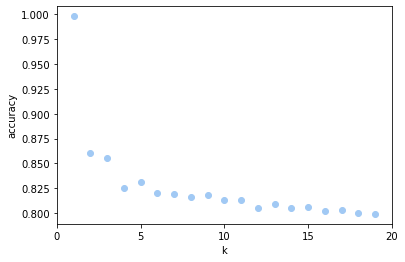

0.8264839613827469

In [ ]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_train, y_train))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()
np.mean(scores)

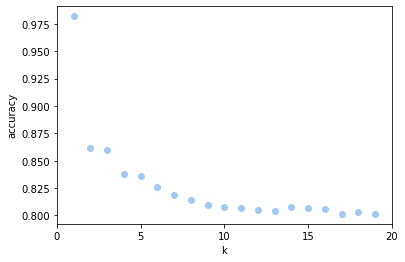

0.8262472749922142

In [ ]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train[c_features], y_train)
    scores.append(knn.score(X_train[c_features], y_train))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()
np.mean(scores)

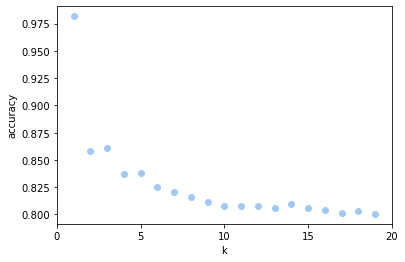

0.8264341326689505

In [ ]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train[['tenure', 'monthly_charges', 'internet_service_type_Fiber optic']], y_train)
    scores.append(knn.score(X_train[['tenure', 'monthly_charges', 'internet_service_type_Fiber optic']], y_train))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()
np.mean(scores)

### Model J
> Logistic Regression
* Parameters: default
* Features: all

In [ ]:
#create, fit, use, model information to model_features dfram
model_j = LogisticRegression(random_state=514)

#feature subset for models
j_features = X_train.columns

#fit model
model_j.fit(X_train[j_features], y_train)

#score model to add to model description dataframe
score = model_j.score(X_train[j_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model J'] = model.compute_metrics(model_j, X_train[j_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[10] = ['Model J', score, 'Logistic Regression', 'all']

### Model K
> Logistic Regression
* Parameters: `C=.1`
* Features: all

In [ ]:
#create, fit, use, model information to model_features dfram
model_k = LogisticRegression(C=.1, random_state=514)

#feature subset for models
k_features = ['tenure', 'monthly_charges', 'internet_service_type_Fiber optic', 'internet_service_type_None']

#fit model
model_k.fit(X_train[k_features], y_train)

#score model to add to model description dataframe
score = model_k.score(X_train[k_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model K'] = model.compute_metrics(model_k, X_train[k_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[11] = ['Model K', score, 'Logistic Regression', 'tenure, monthly charges, internet service type']

### Model L
> Logistic Regression
* Parameters: `C=.5`
* Features: all

In [ ]:
#create, fit, use, model information to model_features dfram
model_l = LogisticRegression(C=.5, class_weight='uniform', random_state=514)

#feature subset for models
l_features = ['tenure', 'monthly_charges', 'internet_service_type_Fiber optic', 'internet_service_type_None']

#fit model
model_l.fit(X_train[l_features], y_train)

# score model to add to model description dataframe
score = model_l.score(X_train[l_features], y_train).round(3)

# compute metrics for model a and assign to comparison dataframe. make sure to put in same features as above
comparison_chart['Model L'] = model.compute_metrics(model_l, X_train[l_features], y_train).values

# add model description to description dataframe
model_descriptions.loc[12] = ['Model L', score, 'Logistic Regression', 'tenure, monthly charges, internet service type']



## Model Description and Comparison Charts


In [ ]:
#model descriptions
model_descriptions

,Model,Accuracy(Score),Type,Features Used
0,Baseline,0.734675,Basic Baseline,Baseline Prediction
1,Model A,0.786000,Decision Tree,"monthly charges, tenure"
2,Model B,0.807000,Decision Tree,All
3,Model C,0.806000,Decision Tree(max_depth=6),"tenure, monthly charges, contract type"
4,Model D,0.890000,Random Forest),all
5,Model E,0.837000,Random Forest),"tenure, monthly charges, contract type"
6,Model F,0.846000,Random Forest),"tenure, monthly charges, contract type, intern..."
7,Model G,0.856000,Random Forest),all
8,Model h,0.859000,Random Forest),"tenure, monthly charges"
9,Model I,0.861000,Random Forest),"tenure, monthly charges, internet service type"


In [ ]:
# model comparison chart
comparison_chart


,Model A,Model B,Model C,Model D,Model E,Model F,Model G,Model H,Model I,Model J,Model K,Model L
Accuracy/Score,0.79,0.81,0.81,0.89,0.84,0.85,0.86,0.86,0.86,0.81,0.79,0.78
True Positives,452.00,616.00,649.00,866.00,750.00,688.00,719.00,749.00,756.00,622.00,505.00,505.00
False Postives,236.00,310.00,349.00,208.00,319.00,216.00,208.00,224.00,223.00,307.00,281.00,293.00
True Negatives,2868.00,2794.00,2755.00,2896.00,2785.00,2888.00,2896.00,2880.00,2881.00,2797.00,2823.00,2811.00
False Negatives,669.00,505.00,472.00,255.00,371.00,433.00,402.00,372.00,365.00,499.00,616.00,616.00
TPR/Recall,0.40,0.55,0.58,0.77,0.67,0.61,0.64,0.67,0.67,0.55,0.45,0.45
False Positive Rate,0.08,0.10,0.11,0.07,0.10,0.07,0.07,0.07,0.07,0.10,0.09,0.09
True Negative Rate,0.92,0.90,0.89,0.93,0.90,0.93,0.93,0.93,0.93,0.90,0.91,0.91
False Negative Rate,0.60,0.45,0.42,0.23,0.33,0.39,0.36,0.33,0.33,0.45,0.55,0.55
Precision,0.66,0.67,0.65,0.81,0.70,0.76,0.78,0.77,0.77,0.67,0.64,0.63


## Model Creation Takeaways
* The Decision Tree and Logistic Regression models did not perform well 
* Best Models are D, G, I 

## Model Validation

In [ ]:
#create validation chart for comparison
validate_comparison = model.create_comp_chart()

#create feature lists if needed 
model_i_features = ['tenure', 'monthly_charges', 'internet_service_type_Fiber optic']

#add metrics to validate comparison dataframe
validate_comparison['Model D'] = model.compute_metrics(model_d, X_validate, y_validate).values
validate_comparison['Model G'] = model.compute_metrics(model_g, X_validate, y_validate).values
validate_comparison['Model I'] = model.compute_metrics(model_i, X_validate[model_i_features], y_validate).values


In [ ]:
validate_comparison

,Model D,Model G,Model I
Accuracy/Score,0.75,0.74,0.76
True Positives,194.00,149.00,174.00
False Postives,166.00,147.00,143.00
True Negatives,869.00,888.00,892.00
False Negatives,180.00,225.00,200.00
TPR/Recall,0.52,0.40,0.47
False Positive Rate,0.16,0.14,0.14
True Negative Rate,0.84,0.86,0.86
False Negative Rate,0.48,0.60,0.53
Precision,0.54,0.50,0.55


### Takeaways
> Initial: All three chosen sets perform baseline. Need to re-adjust and re-attempt

In [ ]:
model.compute_metrics(model_i, X_test[model_i_features], y_test)

0        0.77
1      187.00
2      139.00
3      896.00
4      187.00
5        0.50
6        0.13
7        0.87
8        0.50
9        0.57
10       0.53
11     374.00
12    1035.00
dtype: float64

In [ ]:
# Make Predictions
y_pred = model_i.predict(X_test[model_i_features])

# Estimate Probability 
y_pred_proba = model_i.predict_proba(X_test[model_i_features])

In [ ]:
# final_predictions = pd.DataFrame({'Predictions':y_pred, 'Probability': y_pred_proba})

In [ ]:
y_pred_proba[:,1]

array([0.33333333, 0.33333333, 0.33333333, ..., 0.        , 0.        ,
       0.66666667])

In [ ]:
probabilities = pd.Series(y_pred_proba[:,1], index=X_test.index)

In [ ]:
predictions = pd.Series(y_pred, index=X_test.index)

In [ ]:
final_predictions = pd.DataFrame(pd.concat([probabilities, predictions], axis=1))

In [ ]:
# final_predictions.merge(df[['customer_id']], left_on=final_predictions.index, right_on=df[['customer_id']].index)

In [ ]:
customer_id = df[['customer_id']].iloc[predictions.index]

In [ ]:
final_final_predictions = pd.concat([customer_id, final_predictions], axis=1)

In [ ]:
final_final_predictions.head()

,customer_id,0,1
2899,4130-MZLCC,0.333333,0
55,0096-BXERS,0.333333,0
384,0567-XRHCU,0.333333,0
5828,8203-XJZRC,0.333333,0
188,0303-WMMRN,0.333333,0


In [ ]:
final_final_predictions.columns = ['Customer Id', 'Probabilities', 'Predictions' ]

In [ ]:
final_final_predictions.to_csv('fina_predictions.csv')

# Conclusions 